Zatürre çok yaygın bir hastalıktır. Çeşitleri vardır: 1) Bakteriyel pnömoni 2) Viral Pnömoni 3) Mycoplasma pnömonisi ve 4) Fungal pnömoni. Bu veri kümesi ilk iki sınıfa ait pnömoni örneklerinden oluşmaktadır. Veri kümesi sadece çok az sayıda örnekten oluşmaktadır ve bu da dengesizdir. Bu çalışmanın amacı, bu sınırlı miktardaki veri üzerinde sıfırdan bir derin öğrenme modeli geliştirmektir. 

**Veri Ön İşleme**

In [1]:
import os

# Veri setinin yolu
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# Klasör içeriğini listeleme fonksiyonu (Ana dizindeki klasörleri listeler, ancak '__MACOSX' klasörünü hariç tutar)
folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f)) and f != '__MACOSX'] # '__MACOSX', macOS'ta ZIP dosyalarıyla oluşan ve genellikle gereksiz meta veriler içeren bir sistem klasörüdür.

# Klasör isimlerini ve alt klasörlerini yazdırma
for folder in folders:
    print(f" {folder}:")
    folder_path = os.path.join(data_dir, folder)
    
    # Alt klasörleri listele
    subfolders = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]
    
    for subfolder in subfolders:
        print(f"      {subfolder}")

 chest_xray:
      val
      test
      train
 val:
      PNEUMONIA
      NORMAL
 test:
      PNEUMONIA
      NORMAL
 train:
      PNEUMONIA
      NORMAL


Veri setimizde üç ana klasör bulunmaktadır: 'train' (Eğitim), 'test' (Test) ve 'val' (Doğrulama). Her bir ana klasörde, 'NORMAL' ve 'PNEUMONIA' adlı alt klasörler bulunmakta ve bu alt klasörlerde görseller yer almaktadır. Her bir görselin bulunduğu klasöre göre, 'NORMAL' klasöründeki görseller normal (sağlıklı) bireylere aitken, 'PNEUMONIA' klasöründeki görseller ise zatürre (hastalık) olan bireylere aittir.

In [2]:
import os

# Veri setinin yolu
data_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray"

# Klasör içeriğini listeleme fonksiyonu

folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f)) and f != '__MACOSX']

# Klasör isimlerini, alt klasörlerini ve görsel sayısını yazdırma
for folder in folders:
    print(f" {folder}")
    folder_path = os.path.join(data_dir, folder)
    
    # Alt klasörleri listele
    subfolders = [subfolder for subfolder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, subfolder))]
    
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        
        # Alt klasördeki görsel dosyalarını say
        image_files = [f for f in os.listdir(subfolder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"      {subfolder} - {len(image_files)} images")

 chest_xray
      val - 0 images
      test - 0 images
      train - 0 images
 val
      PNEUMONIA - 8 images
      NORMAL - 8 images
 test
      PNEUMONIA - 390 images
      NORMAL - 234 images
 train
      PNEUMONIA - 3875 images
      NORMAL - 1341 images


val, test, train klasörleri yalnızda alt klasörlerden oluşmaktadır. Görseller alt klasörlerin içerisinde yer almaktadır.

In [3]:
import os
import pandas as pd
from PIL import Image

# Veri dizinleri
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/"
val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val/"
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/"

# Verileri bir DataFrame'e yükleme
def load_data(directory):
    data = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            data.append((image_path, label))
    return pd.DataFrame(data, columns=["image_path", "label"])

train_df = load_data(train_dir)
test_df = load_data(test_dir)
val_df = load_data(val_dir)

# İlk birkaç satırı göster
print(train_df.head())

                                          image_path      label
0  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
1  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
2  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
3  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA
4  /kaggle/input/chest-xray-pneumonia/chest_xray/...  PNEUMONIA


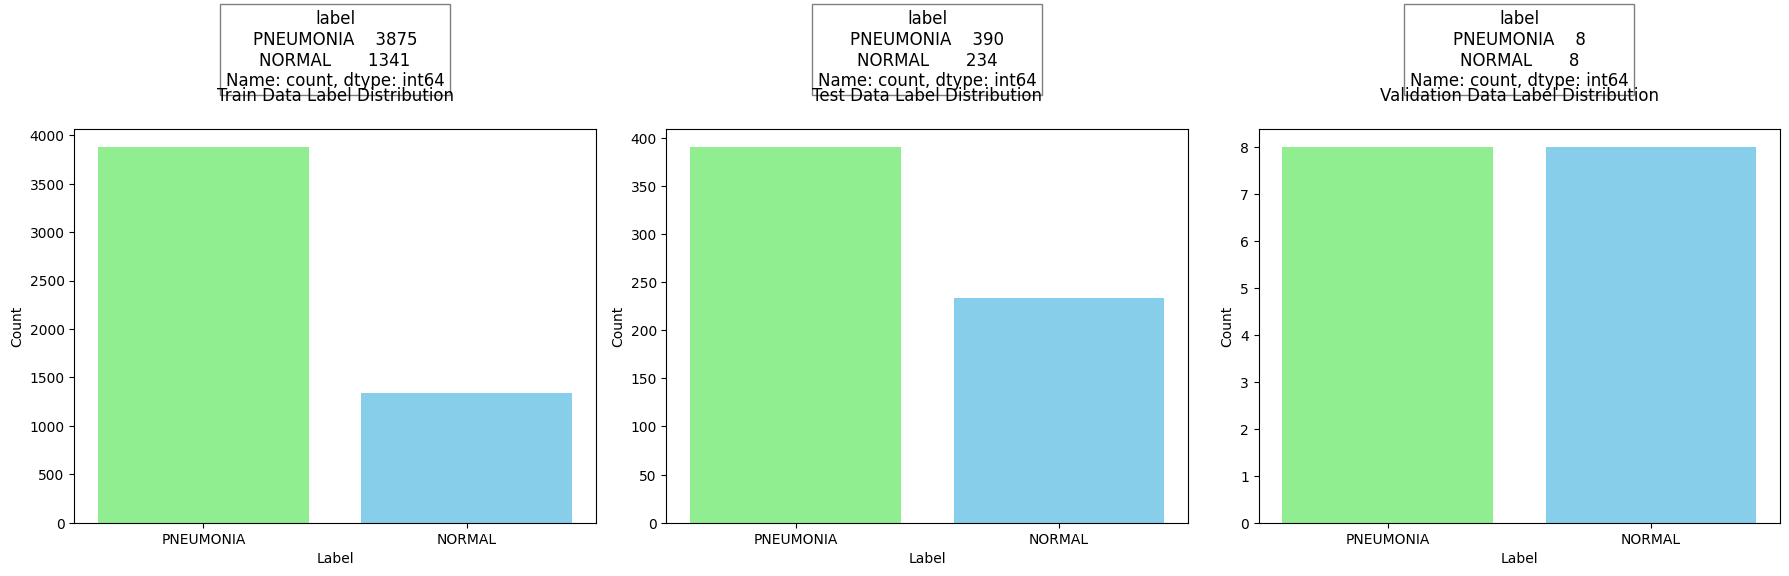

In [4]:
import matplotlib.pyplot as plt

def visualize_label_distribution(train_df, test_df, val_df):
    # Etiket sayılarını hesapla
    train_label_counts = train_df["label"].value_counts()
    test_label_counts = test_df["label"].value_counts()
    val_label_counts = val_df["label"].value_counts()

    # Grafik için figür ve eksenler oluştur
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Figür boyutunu biraz büyüttük

    # Renkler
    colors = {'NORMAL': 'skyblue', 'PNEUMONIA': 'lightgreen'}

    # Train verisi için bar grafiği
    axes[0].bar(train_label_counts.index, train_label_counts.values, color=[colors[label] for label in train_label_counts.index])
    axes[0].set_xlabel("Label")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Train Data Label Distribution", pad=20)  # Başlık ile grafik arasına boşluk ekledik
    # Grafiğin üzerine etiket sayılarını yaz
    axes[0].text(0.5, 1.2, str(train_label_counts), transform=axes[0].transAxes, ha='center', va='center', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    # Test verisi için bar grafiği
    axes[1].bar(test_label_counts.index, test_label_counts.values, color=[colors[label] for label in test_label_counts.index])
    axes[1].set_xlabel("Label")
    axes[1].set_ylabel("Count")
    axes[1].set_title("Test Data Label Distribution", pad=20)  # Başlık ile grafik arasına boşluk ekledik
    # Grafiğin üzerine etiket sayılarını yaz
    axes[1].text(0.5, 1.2, str(test_label_counts), transform=axes[1].transAxes, ha='center', va='center', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    # Validation verisi için bar grafiği
    axes[2].bar(val_label_counts.index, val_label_counts.values, color=[colors[label] for label in val_label_counts.index])
    axes[2].set_xlabel("Label")
    axes[2].set_ylabel("Count")
    axes[2].set_title("Validation Data Label Distribution", pad=20)  # Başlık ile grafik arasına boşluk ekledik
    # Grafiğin üzerine etiket sayılarını yaz
    axes[2].text(0.5, 1.2, str(val_label_counts), transform=axes[2].transAxes, ha='center', va='center', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

    # Grafikleri göster
    plt.tight_layout()
    plt.show()

# Etiket dağılımını görselleştirme
visualize_label_distribution(train_df, test_df, val_df)

Veriler dengesiz. Train setinde NORMAL sınıfı 3875 görsele; Test setinde NORMAL sınıfı 390 görsele tamamlanmalı.

In [5]:
import os
import cv2
import random

# Görsellerin bulunduğu dizin
input_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/'  # Kendi dizininizi buraya girin

# Dizindeki tüm görselleri al
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Rastgele 10 görsel seç
random_images = random.sample(image_files, 10)

# Her bir görselin boyutlarını yazdır
for image_file in random_images:
    image_path = os.path.join(input_dir, image_file)
    
    # Görseli yükle
    image = cv2.imread(image_path)
    
    # Görselin boyutlarını al (yükseklik, genişlik)
    height, width = image.shape[:2]
    
    # Boyutları ekrana yazdır
    print(f"{height}x{width}")

1341x1704
1634x1956
1144x1588
2534x2890
2012x2512
1248x1604
1654x1790
1360x1666
1480x1762
1441x1654


Görsellerin boyutları çok büyük ve birbirinden farklı.

**Gürültü Giderme (Gaussian filter)**

In [6]:
import os
import cv2
import numpy as np

# Görsellerin bulunduğu dizin ve çıktı dizini
input_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL/'  # Görsellerin bulunduğu dizin
output_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/processed_train/NORMAL/'  # İşlenmiş görsellerin kaydedileceği dizin

# Eğer çıktı dizini yoksa oluştur
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dizindeki tüm görselleri al
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Toplam görsel sayısını al
total_images = len(image_files)

# Her bir görsel üzerinde işlem yap
for i, image_file in enumerate(image_files):
    # Görselin tam yolunu oluştur
    image_path = os.path.join(input_dir, image_file)
    
    # Görseli yükle
    image = cv2.imread(image_path)
    
    # Gaussian filtresi uygula
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
    
    # İşlenmiş görseli kaydet
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, gaussian_blur)

print(f"İşlem tamamlandı! İşlenmiş görseller {output_dir} dizinine kaydedildi.")

İşlem tamamlandı! İşlenmiş görseller /kaggle/working/chest-xray-pneumonia/chest_xray/processed_train/NORMAL/ dizinine kaydedildi.


In [7]:
import os
import cv2
import numpy as np

# Görsellerin bulunduğu dizin ve çıktı dizini
input_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'  # Görsellerin bulunduğu dizin
output_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/processed_train/PNEUMONIA/'  # İşlenmiş görsellerin kaydedileceği dizin

# Eğer çıktı dizini yoksa oluştur
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dizindeki tüm görselleri al
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Toplam görsel sayısını al
total_images = len(image_files)

# Her bir görsel üzerinde işlem yap
for i, image_file in enumerate(image_files):
    # Görselin tam yolunu oluştur
    image_path = os.path.join(input_dir, image_file)
    
    # Görseli yükle
    image = cv2.imread(image_path)
    
    # Gaussian filtresi uygula
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
    
    # İşlenmiş görseli kaydet
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, gaussian_blur)

print(f"İşlem tamamlandı! İşlenmiş görseller {output_dir} dizinine kaydedildi.")

İşlem tamamlandı! İşlenmiş görseller /kaggle/working/chest-xray-pneumonia/chest_xray/processed_train/PNEUMONIA/ dizinine kaydedildi.


In [8]:
import os
import cv2
import numpy as np

# Görsellerin bulunduğu dizin ve çıktı dizini
input_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/'  # Görsellerin bulunduğu dizin
output_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/processed_test/NORMAL/'  # İşlenmiş görsellerin kaydedileceği dizin

# Eğer çıktı dizini yoksa oluştur
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dizindeki tüm görselleri al
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Toplam görsel sayısını al
total_images = len(image_files)

# Her bir görsel üzerinde işlem yap
for i, image_file in enumerate(image_files):
    # Görselin tam yolunu oluştur
    image_path = os.path.join(input_dir, image_file)
    
    # Görseli yükle
    image = cv2.imread(image_path)
    
    # Gaussian filtresi uygula
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
    
    # İşlenmiş görseli kaydet
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, gaussian_blur)

print(f"İşlem tamamlandı! İşlenmiş görseller {output_dir} dizinine kaydedildi.")

İşlem tamamlandı! İşlenmiş görseller /kaggle/working/chest-xray-pneumonia/chest_xray/processed_test/NORMAL/ dizinine kaydedildi.


In [9]:
import os
import cv2
import numpy as np

# Görsellerin bulunduğu dizin ve çıktı dizini
input_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'  # Görsellerin bulunduğu dizin
output_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/processed_test/PNEUMONIA/'  # İşlenmiş görsellerin kaydedileceği dizin

# Eğer çıktı dizini yoksa oluştur
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dizindeki tüm görselleri al
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Toplam görsel sayısını al
total_images = len(image_files)

# Her bir görsel üzerinde işlem yap
for i, image_file in enumerate(image_files):
    # Görselin tam yolunu oluştur
    image_path = os.path.join(input_dir, image_file)
    
    # Görseli yükle
    image = cv2.imread(image_path)
    
    # Gaussian filtresi uygula
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
    
    # İşlenmiş görseli kaydet
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, gaussian_blur)

print(f"İşlem tamamlandı! İşlenmiş görseller {output_dir} dizinine kaydedildi.")

İşlem tamamlandı! İşlenmiş görseller /kaggle/working/chest-xray-pneumonia/chest_xray/processed_test/PNEUMONIA/ dizinine kaydedildi.


In [10]:
import os
import cv2
import numpy as np

# Görsellerin bulunduğu dizin ve çıktı dizini
input_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/'  # Görsellerin bulunduğu dizin
output_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/processed_val/NORMAL/'  # İşlenmiş görsellerin kaydedileceği dizin

# Eğer çıktı dizini yoksa oluştur
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dizindeki tüm görselleri al
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Toplam görsel sayısını al
total_images = len(image_files)

# Her bir görsel üzerinde işlem yap
for i, image_file in enumerate(image_files):
    # Görselin tam yolunu oluştur
    image_path = os.path.join(input_dir, image_file)
    
    # Görseli yükle
    image = cv2.imread(image_path)
    
    # Gaussian filtresi uygula
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
    
    # İşlenmiş görseli kaydet
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, gaussian_blur)

print(f"İşlem tamamlandı! İşlenmiş görseller {output_dir} dizinine kaydedildi.")

İşlem tamamlandı! İşlenmiş görseller /kaggle/working/chest-xray-pneumonia/chest_xray/processed_val/NORMAL/ dizinine kaydedildi.


In [11]:
import os
import cv2
import numpy as np

# Görsellerin bulunduğu dizin ve çıktı dizini
input_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/'  # Görsellerin bulunduğu dizin
output_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/processed_val/PNEUMONIA/'  # İşlenmiş görsellerin kaydedileceği dizin

# Eğer çıktı dizini yoksa oluştur
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dizindeki tüm görselleri al
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Toplam görsel sayısını al
total_images = len(image_files)

# Her bir görsel üzerinde işlem yap
for i, image_file in enumerate(image_files):
    # Görselin tam yolunu oluştur
    image_path = os.path.join(input_dir, image_file)
    
    # Görseli yükle
    image = cv2.imread(image_path)
    
    # Gaussian filtresi uygula
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
    
    # İşlenmiş görseli kaydet
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, gaussian_blur)

print(f"İşlem tamamlandı! İşlenmiş görseller {output_dir} dizinine kaydedildi.")

İşlem tamamlandı! İşlenmiş görseller /kaggle/working/chest-xray-pneumonia/chest_xray/processed_val/PNEUMONIA/ dizinine kaydedildi.


**CLAHE (Contrast Limited Adaptive Histogram Equalization)**

In [12]:
import os
import cv2
import numpy as np

# Görsellerin bulunduğu dizin ve çıktı dizini
input_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/processed_train/NORMAL/'  # Görsellerin bulunduğu dizin
output_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_train/NORMAL/'  # İşlenmiş görsellerin kaydedileceği dizin

# Eğer çıktı dizini yoksa oluştur
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dizindeki tüm görselleri al
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Her bir görsel üzerinde işlem yap
for image_file in image_files:
    # Görselin tam yolunu oluştur
    image_path = os.path.join(input_dir, image_file)
    
    # Görseli yükle
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Gri tonlamalı olarak yükle
    
    # CLAHE uygula
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    
    # İşlenmiş görseli kaydet
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, clahe_image)

print(f"İşlem tamamlandı! İşlenmiş görseller {output_dir} dizinine kaydedildi.")

İşlem tamamlandı! İşlenmiş görseller /kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_train/NORMAL/ dizinine kaydedildi.


In [13]:
import os
import cv2
import numpy as np

# Görsellerin bulunduğu dizin ve çıktı dizini
input_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/processed_train/PNEUMONIA/'  # Görsellerin bulunduğu dizin
output_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_train/PNEUMONIA/'  # İşlenmiş görsellerin kaydedileceği dizin

# Eğer çıktı dizini yoksa oluştur
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dizindeki tüm görselleri al
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Her bir görsel üzerinde işlem yap
for image_file in image_files:
    # Görselin tam yolunu oluştur
    image_path = os.path.join(input_dir, image_file)
    
    # Görseli yükle
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Gri tonlamalı olarak yükle
    
    # CLAHE uygula
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    
    # İşlenmiş görseli kaydet
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, clahe_image)

print(f"İşlem tamamlandı! İşlenmiş görseller {output_dir} dizinine kaydedildi.")

İşlem tamamlandı! İşlenmiş görseller /kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_train/PNEUMONIA/ dizinine kaydedildi.


In [14]:
import os
import cv2
import numpy as np

# Görsellerin bulunduğu dizin ve çıktı dizini
input_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/processed_test/NORMAL/'  # Görsellerin bulunduğu dizin
output_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_test/NORMAL/'  # İşlenmiş görsellerin kaydedileceği dizin

# Eğer çıktı dizini yoksa oluştur
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dizindeki tüm görselleri al
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Her bir görsel üzerinde işlem yap
for image_file in image_files:
    # Görselin tam yolunu oluştur
    image_path = os.path.join(input_dir, image_file)
    
    # Görseli yükle
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Gri tonlamalı olarak yükle
    
    # CLAHE uygula
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    
    # İşlenmiş görseli kaydet
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, clahe_image)

print(f"İşlem tamamlandı! İşlenmiş görseller {output_dir} dizinine kaydedildi.")

İşlem tamamlandı! İşlenmiş görseller /kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_test/NORMAL/ dizinine kaydedildi.


In [15]:
import os
import cv2
import numpy as np

# Görsellerin bulunduğu dizin ve çıktı dizini
input_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/processed_test/PNEUMONIA/'  # Görsellerin bulunduğu dizin
output_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_test/PNEUMONIA/'  # İşlenmiş görsellerin kaydedileceği dizin

# Eğer çıktı dizini yoksa oluştur
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dizindeki tüm görselleri al
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Her bir görsel üzerinde işlem yap
for image_file in image_files:
    # Görselin tam yolunu oluştur
    image_path = os.path.join(input_dir, image_file)
    
    # Görseli yükle
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Gri tonlamalı olarak yükle
    
    # CLAHE uygula
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    
    # İşlenmiş görseli kaydet
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, clahe_image)

print(f"İşlem tamamlandı! İşlenmiş görseller {output_dir} dizinine kaydedildi.")

İşlem tamamlandı! İşlenmiş görseller /kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_test/PNEUMONIA/ dizinine kaydedildi.


In [16]:
import os
import cv2
import numpy as np

# Görsellerin bulunduğu dizin ve çıktı dizini
input_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/processed_val/NORMAL/'  # Görsellerin bulunduğu dizin
output_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_val/NORMAL/'  # İşlenmiş görsellerin kaydedileceği dizin

# Eğer çıktı dizini yoksa oluştur
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dizindeki tüm görselleri al
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Her bir görsel üzerinde işlem yap
for image_file in image_files:
    # Görselin tam yolunu oluştur
    image_path = os.path.join(input_dir, image_file)
    
    # Görseli yükle
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Gri tonlamalı olarak yükle
    
    # CLAHE uygula
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    
    # İşlenmiş görseli kaydet
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, clahe_image)

print(f"İşlem tamamlandı! İşlenmiş görseller {output_dir} dizinine kaydedildi.")

İşlem tamamlandı! İşlenmiş görseller /kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_val/NORMAL/ dizinine kaydedildi.


In [17]:
import os
import cv2
import numpy as np

# Görsellerin bulunduğu dizin ve çıktı dizini
input_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/processed_val/PNEUMONIA/'  # Görsellerin bulunduğu dizin
output_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_val/PNEUMONIA/'  # İşlenmiş görsellerin kaydedileceği dizin

# Eğer çıktı dizini yoksa oluştur
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Dizindeki tüm görselleri al
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Her bir görsel üzerinde işlem yap
for image_file in image_files:
    # Görselin tam yolunu oluştur
    image_path = os.path.join(input_dir, image_file)
    
    # Görseli yükle
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Gri tonlamalı olarak yükle
    
    # CLAHE uygula
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(image)
    
    # İşlenmiş görseli kaydet
    output_path = os.path.join(output_dir, image_file)
    cv2.imwrite(output_path, clahe_image)

print(f"İşlem tamamlandı! İşlenmiş görseller {output_dir} dizinine kaydedildi.")

İşlem tamamlandı! İşlenmiş görseller /kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_val/PNEUMONIA/ dizinine kaydedildi.


**Sentetik veri üreterek dengesiz sınıfları dengeleme**

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os

# Kullanılacak klasör
folder_path = '/kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_train/NORMAL/'  # NORMAL görüntülerin olduğu klasör

# Mevcut ve hedef görüntü sayıları
current_count = len(os.listdir(folder_path))
target_count = 3875  # PNEUMONIA ile eşitlemek için
num_needed = target_count - current_count  # Kaç yeni görüntü üretilecek?

# Eğer zaten hedefe ulaşılmışsa işlem yapma
if num_needed <= 0:
    print(f"Zaten {target_count} veya daha fazla görüntü var, veri artırmaya gerek yok.")
    exit()

# Veri artırma parametreleri
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Görselleri yükle
images = os.listdir(folder_path)

i = 0
while current_count < target_count:
    img_name = images[i % len(images)]  # Döngü ile sırayla seç
    img_path = os.path.join(folder_path, img_name)
    img = cv2.imread(img_path)
    
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.expand_dims(img, axis=0)

        # Veri artırma
        for batch in datagen.flow(img, batch_size=1, save_to_dir=folder_path, save_prefix="aug", save_format="jpeg"):
            current_count += 1
            i += 1
            if current_count >= target_count:
                break

print(f"Veri artırma tamamlandı. NORMAL sınıfı {target_count} görsele tamamlandı.")

Veri artırma tamamlandı. NORMAL sınıfı 3875 görsele tamamlandı.


In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os

# Kullanılacak klasör
folder_path = '/kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_test/NORMAL/'  # NORMAL görüntülerin olduğu klasör

# Mevcut ve hedef görüntü sayıları
current_count = len(os.listdir(folder_path))
target_count = 390  # PNEUMONIA ile eşitlemek için
num_needed = target_count - current_count  # Kaç yeni görüntü üretilecek?

# Eğer zaten hedefe ulaşılmışsa işlem yapma
if num_needed <= 0:
    print(f"Zaten {target_count} veya daha fazla görüntü var, veri artırmaya gerek yok.")
    exit()

# Veri artırma parametreleri
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Görselleri yükle
images = os.listdir(folder_path)

i = 0
while current_count < target_count:
    img_name = images[i % len(images)]  # Döngü ile sırayla seç
    img_path = os.path.join(folder_path, img_name)
    img = cv2.imread(img_path)
    
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.expand_dims(img, axis=0)

        # Veri artırma
        for batch in datagen.flow(img, batch_size=1, save_to_dir=folder_path, save_prefix="aug", save_format="jpeg"):
            current_count += 1
            i += 1
            if current_count >= target_count:
                break

print(f"Veri artırma tamamlandı. NORMAL sınıfı {target_count} görsele tamamlandı.")

Veri artırma tamamlandı. NORMAL sınıfı 390 görsele tamamlandı.


Görüntü sayıları eşitlendi.

**Görüntü boyutlarını indirgeme (224x224)**

In [20]:
from PIL import Image
import os

def resize_image(input_path, output_path, size=(224, 224)):
    try:
        # Görüntüyü aç
        with Image.open(input_path) as img:
            # Görüntüyü yeniden boyutlandır (LANCZOS kullanarak)
            img = img.resize(size, Image.Resampling.LANCZOS)
            # Yeniden boyutlandırılmış görüntüyü kaydet
            img.save(output_path)
    except Exception as e:
        print(f"Hata oluştu: {e}")

def resize_images_in_directory(input_dir, output_dir, size=(224, 224)):
    # Eğer output dizini yoksa oluştur
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # İşlenen dosya sayısını takip etmek için sayaç
    processed_files = 0
    skipped_files = 0

    # Dizin içindeki tüm dosyaları listele
    for filename in os.listdir(input_dir):
        # Dosya yolunu oluştur
        input_image_path = os.path.join(input_dir, filename)
        output_image_path = os.path.join(output_dir, filename)

        # Sadece geçerli görüntü dosyalarını işle (örneğin .jpg, .png)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            resize_image(input_image_path, output_image_path, size)
            processed_files += 1
        else:
            skipped_files += 1

    # İşlem tamamlandığında özet bilgi yazdır
    print(f"İşlem tamamlandı: {processed_files} görüntü yeniden boyutlandırıldı, {skipped_files} dosya atlandı.")

# Örnek kullanım
input_image_dir = "/kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_train/NORMAL/"
output_image_dir = "/kaggle/working/chest-xray-pneumonia/chest_xray/resized-CLAHED-train/NORMAL/"
resize_images_in_directory(input_image_dir, output_image_dir)

İşlem tamamlandı: 3578 görüntü yeniden boyutlandırıldı, 0 dosya atlandı.


In [21]:
from PIL import Image
import os

def resize_image(input_path, output_path, size=(224, 224)):
    try:
        # Görüntüyü aç
        with Image.open(input_path) as img:
            # Görüntüyü yeniden boyutlandır (LANCZOS kullanarak)
            img = img.resize(size, Image.Resampling.LANCZOS)
            # Yeniden boyutlandırılmış görüntüyü kaydet
            img.save(output_path)
    except Exception as e:
        print(f"Hata oluştu: {e}")

def resize_images_in_directory(input_dir, output_dir, size=(224, 224)):
    # Eğer output dizini yoksa oluştur
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # İşlenen dosya sayısını takip etmek için sayaç
    processed_files = 0
    skipped_files = 0

    # Dizin içindeki tüm dosyaları listele
    for filename in os.listdir(input_dir):
        # Dosya yolunu oluştur
        input_image_path = os.path.join(input_dir, filename)
        output_image_path = os.path.join(output_dir, filename)

        # Sadece geçerli görüntü dosyalarını işle (örneğin .jpg, .png)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            resize_image(input_image_path, output_image_path, size)
            processed_files += 1
        else:
            skipped_files += 1

    # İşlem tamamlandığında özet bilgi yazdır
    print(f"İşlem tamamlandı: {processed_files} görüntü yeniden boyutlandırıldı, {skipped_files} dosya atlandı.")

# Örnek kullanım
input_image_dir = "/kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_train/PNEUMONIA/"
output_image_dir = "/kaggle/working/chest-xray-pneumonia/chest_xray/resized-CLAHED-train/PNEUMONIA/"
resize_images_in_directory(input_image_dir, output_image_dir)

İşlem tamamlandı: 3875 görüntü yeniden boyutlandırıldı, 0 dosya atlandı.


In [22]:
from PIL import Image
import os

def resize_image(input_path, output_path, size=(224, 224)):
    try:
        # Görüntüyü aç
        with Image.open(input_path) as img:
            # Görüntüyü yeniden boyutlandır (LANCZOS kullanarak)
            img = img.resize(size, Image.Resampling.LANCZOS)
            # Yeniden boyutlandırılmış görüntüyü kaydet
            img.save(output_path)
    except Exception as e:
        print(f"Hata oluştu: {e}")

def resize_images_in_directory(input_dir, output_dir, size=(224, 224)):
    # Eğer output dizini yoksa oluştur
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # İşlenen dosya sayısını takip etmek için sayaç
    processed_files = 0
    skipped_files = 0

    # Dizin içindeki tüm dosyaları listele
    for filename in os.listdir(input_dir):
        # Dosya yolunu oluştur
        input_image_path = os.path.join(input_dir, filename)
        output_image_path = os.path.join(output_dir, filename)

        # Sadece geçerli görüntü dosyalarını işle (örneğin .jpg, .png)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            resize_image(input_image_path, output_image_path, size)
            processed_files += 1
        else:
            skipped_files += 1

    # İşlem tamamlandığında özet bilgi yazdır
    print(f"İşlem tamamlandı: {processed_files} görüntü yeniden boyutlandırıldı, {skipped_files} dosya atlandı.")

# Örnek kullanım
input_image_dir = "/kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_test/NORMAL/"
output_image_dir = "/kaggle/working/chest-xray-pneumonia/chest_xray/resized-CLAHED-test/NORMAL/"
resize_images_in_directory(input_image_dir, output_image_dir)

İşlem tamamlandı: 389 görüntü yeniden boyutlandırıldı, 0 dosya atlandı.


In [23]:
from PIL import Image
import os

def resize_image(input_path, output_path, size=(224, 224)):
    try:
        # Görüntüyü aç
        with Image.open(input_path) as img:
            # Görüntüyü yeniden boyutlandır (LANCZOS kullanarak)
            img = img.resize(size, Image.Resampling.LANCZOS)
            # Yeniden boyutlandırılmış görüntüyü kaydet
            img.save(output_path)
    except Exception as e:
        print(f"Hata oluştu: {e}")

def resize_images_in_directory(input_dir, output_dir, size=(224, 224)):
    # Eğer output dizini yoksa oluştur
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # İşlenen dosya sayısını takip etmek için sayaç
    processed_files = 0
    skipped_files = 0

    # Dizin içindeki tüm dosyaları listele
    for filename in os.listdir(input_dir):
        # Dosya yolunu oluştur
        input_image_path = os.path.join(input_dir, filename)
        output_image_path = os.path.join(output_dir, filename)

        # Sadece geçerli görüntü dosyalarını işle (örneğin .jpg, .png)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            resize_image(input_image_path, output_image_path, size)
            processed_files += 1
        else:
            skipped_files += 1

    # İşlem tamamlandığında özet bilgi yazdır
    print(f"İşlem tamamlandı: {processed_files} görüntü yeniden boyutlandırıldı, {skipped_files} dosya atlandı.")

# Örnek kullanım
input_image_dir = "/kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_test/PNEUMONIA/"
output_image_dir = "/kaggle/working/chest-xray-pneumonia/chest_xray/resized-CLAHED-test/PNEUMONIA/"
resize_images_in_directory(input_image_dir, output_image_dir)

İşlem tamamlandı: 390 görüntü yeniden boyutlandırıldı, 0 dosya atlandı.


In [24]:
from PIL import Image
import os

def resize_image(input_path, output_path, size=(224, 224)):
    try:
        # Görüntüyü aç
        with Image.open(input_path) as img:
            # Görüntüyü yeniden boyutlandır (LANCZOS kullanarak)
            img = img.resize(size, Image.Resampling.LANCZOS)
            # Yeniden boyutlandırılmış görüntüyü kaydet
            img.save(output_path)
    except Exception as e:
        print(f"Hata oluştu: {e}")

def resize_images_in_directory(input_dir, output_dir, size=(224, 224)):
    # Eğer output dizini yoksa oluştur
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # İşlenen dosya sayısını takip etmek için sayaç
    processed_files = 0
    skipped_files = 0

    # Dizin içindeki tüm dosyaları listele
    for filename in os.listdir(input_dir):
        # Dosya yolunu oluştur
        input_image_path = os.path.join(input_dir, filename)
        output_image_path = os.path.join(output_dir, filename)

        # Sadece geçerli görüntü dosyalarını işle (örneğin .jpg, .png)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            resize_image(input_image_path, output_image_path, size)
            processed_files += 1
        else:
            skipped_files += 1

    # İşlem tamamlandığında özet bilgi yazdır
    print(f"İşlem tamamlandı: {processed_files} görüntü yeniden boyutlandırıldı, {skipped_files} dosya atlandı.")

# Örnek kullanım
input_image_dir = "/kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_val/NORMAL/"
output_image_dir = "/kaggle/working/chest-xray-pneumonia/chest_xray/resized-CLAHED-val/NORMAL/"
resize_images_in_directory(input_image_dir, output_image_dir)

İşlem tamamlandı: 8 görüntü yeniden boyutlandırıldı, 0 dosya atlandı.


In [25]:
from PIL import Image
import os

def resize_image(input_path, output_path, size=(224, 224)):
    try:
        # Görüntüyü aç
        with Image.open(input_path) as img:
            # Görüntüyü yeniden boyutlandır (LANCZOS kullanarak)
            img = img.resize(size, Image.Resampling.LANCZOS)
            # Yeniden boyutlandırılmış görüntüyü kaydet
            img.save(output_path)
    except Exception as e:
        print(f"Hata oluştu: {e}")

def resize_images_in_directory(input_dir, output_dir, size=(224, 224)):
    # Eğer output dizini yoksa oluştur
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # İşlenen dosya sayısını takip etmek için sayaç
    processed_files = 0
    skipped_files = 0

    # Dizin içindeki tüm dosyaları listele
    for filename in os.listdir(input_dir):
        # Dosya yolunu oluştur
        input_image_path = os.path.join(input_dir, filename)
        output_image_path = os.path.join(output_dir, filename)

        # Sadece geçerli görüntü dosyalarını işle (örneğin .jpg, .png)
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            resize_image(input_image_path, output_image_path, size)
            processed_files += 1
        else:
            skipped_files += 1

    # İşlem tamamlandığında özet bilgi yazdır
    print(f"İşlem tamamlandı: {processed_files} görüntü yeniden boyutlandırıldı, {skipped_files} dosya atlandı.")

# Örnek kullanım
input_image_dir = "/kaggle/working/chest-xray-pneumonia/chest_xray/CLAHE/CLAHE_val/PNEUMONIA/"
output_image_dir = "/kaggle/working/chest-xray-pneumonia/chest_xray/resized-CLAHED-val/PNEUMONIA/"
resize_images_in_directory(input_image_dir, output_image_dir)

İşlem tamamlandı: 8 görüntü yeniden boyutlandırıldı, 0 dosya atlandı.


In [26]:
import os
import cv2
import random

# Görsellerin bulunduğu dizin
input_dir = '/kaggle/working/chest-xray-pneumonia/chest_xray/resized-CLAHED-test/NORMAL/'  # Kendi dizininizi buraya girin

# Dizindeki tüm görselleri al
image_files = [f for f in os.listdir(input_dir) if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))]

# Rastgele 10 görsel seç
random_images = random.sample(image_files, 10)

# Her bir görselin boyutlarını yazdır
for image_file in random_images:
    image_path = os.path.join(input_dir, image_file)
    
    # Görseli yükle
    image = cv2.imread(image_path)
    
    # Görselin boyutlarını al (yükseklik, genişlik)
    height, width = image.shape[:2]
    
    # Boyutları ekrana yazdır
    print(f"{height}x{width}")

224x224
224x224
224x224
224x224
224x224
224x224
224x224
224x224
224x224
224x224


**Veri setini indirme**

In [27]:
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))

# Klasör yolunu belirtin
folder_path = '/kaggle/working/chest-xray-pneumonia'

# ZIP dosyasının adını belirtin
zipf = zipfile.ZipFile('/kaggle/working/chest_xray-pneumonia.zip', 'w', zipfile.ZIP_DEFLATED)

# Klasörü ZIP'e ekleyin
zipdir(folder_path, zipf)

# ZIP dosyasını kapatın
zipf.close()

# ZIP dosyasını indirin
from IPython.display import FileLink
FileLink('/kaggle/working/chest_xray.zip')

/kaggle/working/chest_xray.zip